In [1]:
# colabへのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ライブラリとデータの読み込み

In [2]:
!pip install kanjize

In [3]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.1 MB/s eta 0:00:00


In [5]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import seaborn as sns
import kanjize
import re
import unicodedata
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# データの読み込み
train = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/test.csv")


# 各列に対する処理の関数を用意

In [6]:
def convert_to_int(age):
    """
    年齢の表記を統一する関数
    :param age: 年齢の文字列または数値
    :return: 整数に変換された年齢
    """
    if pd.isna(age):
        return np.nan

    age_str = str(age)

    # 全角を半角に変換
    age_str = age_str.translate(str.maketrans('０１２３４５６７８９', '0123456789'))

    # 数字のみにする
    pattern = r'[0-9零一二三四五六七八九十百千万億兆京垓𥝱穣溝澗正載極恒河沙阿僧祇那由他不可思議無量大数]'
    age_str_list = re.findall(pattern, age_str)
    # リストを文字列に変換
    age_str = ''.join(age_str_list)

    # 数字でないものをフィルタリング
    if age_str.isdigit():
        return int(age_str)

    # 漢数字をアラビア数字に変換
    try:
        return kanjize.kanji2number(age_str)
    except ValueError:
        return np.nan


def check_not_int(check_value):
    """
    数値と小数点以外の文字が含まれているかを確認する関数
    :param check_value: チェックする値
    :return: 数字以外の文字
    """
    check_str = str(check_value)
    pattern = r"[0-9.]"
    non_digit_chars = re.sub(pattern, '', check_str)
    return non_digit_chars


def convert_to_seconds(duration):
    """
    DurationOfPitchの時間表記を秒に変換する関数
    :param duration: 時間表記の文字列
    :return: 秒に変換された値
    """
    if pd.isna(duration):
        return None
    elif '時間' in duration or '時' in duration:
        hours = int(duration.replace('時間', '').replace('時', ''))
        return hours * 3600
    elif '分' in duration:
        minutes = int(duration.replace('分', ''))
        return minutes * 60
    elif '秒' in duration:
        return int(duration.replace('秒', ''))
    else:
        return int(duration)


def convert_to_number(s):
    """
    NumberOfTripsの値を数値に変換する関数
    :param s: 旅行回数の文字列
    :return: 数値に変換された旅行回数
    """
    # nanチェック
    if pd.isnull(s):
        return s

    # 全角数字を半角数字に変換
    s = s.translate(str.maketrans('０１２３４５６７８９', '0123456789'))

    if '半年に' in s:
        return int(re.sub(r'\D', '', s)) * 2
    elif '年に' in s:
        return int(re.sub(r'\D', '', s))
    elif '四半期に' in s:
        return int(re.sub(r'\D', '', s)) * 4
    else:
        return int(s)


def normalize_string(s):
    """
    性別などの表記を統一するために、文字列を正規化する関数
    :param s: 文字列
    :return: 正規化された文字列
    """
    return unicodedata.normalize('NFKC', s).lower().replace(' ', '')


def standardize_column(df):
    """
    ProductPitchedの表記揺れを修正する関数
    :param df: DataFrame
    :return: 修正されたDateFrame
    """
    df["ProductPitched"] = df["ProductPitched"].str.lower()
    df['ProductPitched'] = df['ProductPitched'].str.replace('basic', 'basic').str.replace('superde|uxe', 'super deluxe').str.replace('supεrꭰeluxe', 'super deluxe').str.replace('stαndard', 'standard').str.replace('de|uxe', 'deluxe').str.replace('stanᗞard', 'standard').str.replace('kıng', 'king').str.replace('king', 'king').str.replace('baｓıc', 'basic').str.replace('𝙳eluxe', 'deluxe').str.replace('ᗞeluxe', 'deluxe').str.replace('baտic', 'basic').str.replace('dεluxε', 'deluxe').str.replace('ꓢuperdeluxe', 'super deluxe').str.replace('basιс', 'basic').str.replace('basiϲ', 'basic').str.replace('kıոg', 'king').str.replace('ꭰe|uxe', 'deluxe').str.replace('baꓢic', 'basic').str.replace('standarꭰ', 'standard').str.replace('de|u×e', 'deluxe').str.replace('superdelu×e', 'super deluxe').str.replace('bαsic', 'basic').str.replace('ѕuperdeluxe', 'super deluxe').str.replace('𐊡asic', 'basic').str.replace('bası𝘤', 'basic').str.replace('delu×e', 'deluxe').str.replace('βasic', 'basic').str.replace('ｓuperdeluxe', 'super deluxe').str.replace('kiոg', 'king').str.replace('basıϲ', 'basic').str.replace('ꓢtandard', 'standard').str.replace('s𝘵andard', 'standard').str.replace('ꓢuperde|uxe', 'super deluxe').str.replace('вasic', 'basic').str.replace('b𝖺si𝘤', 'basic').str.replace('βası𝘤', 'basic').str.replace('βasiс', 'basic').str.replace('ѕtandard', 'standard').str.replace('staոdard', 'standard').str.replace('deluxe', 'deluxe').str.replace('baѕic', 'basic').str.replace('standar𝔡', 'standard').str.replace('𐊡asi𝘤', 'basic').str.replace('stand𝖺rd', 'standard').str.replace('в𝖺sic', 'basic').str.replace('super𝙳eluxe', 'super deluxe').str.replace('s𝘵𝖺nda𝘳d', 'standard').str.replace('standard', 'standard').str.replace('ꭰeluxe', 'deluxe').str.replace('basıc', 'basic').str.replace('superdeluxe', 'super deluxe').str.replace('st𝖺ndard', 'standard').str.replace('basi𝘤', 'basic').str.replace('տuperdeluxe', 'super deluxe').str.replace('superᗞeluxe', 'super deluxe').str.replace('superꭰeluxe', 'super deluxe').str.replace('superdεluxe', 'super deluxe').str.replace('deluxε', 'deluxe').str.replace('տtanda𝘳d', 'standard').str.replace('b𝖺sic', 'basic').str.replace('basiс', 'basic').str.replace('basιc', 'basic').str.replace('standa𝘳d', 'standard').str.replace('stand𝖺𝘳d', 'standard').str.replace('տtandard', 'standard').str.replace('βasıc', 'basic').str.replace('baｓic', 'basic').str.replace('stan𝔡ard', 'standard').str.replace('super dεluxe', 'super deluxe').str.replace('super dεluxe', 'super deluxe').str.replace('ѕuper deluxe', 'super deluxe').str.replace('տuper deluxe', 'super deluxe').str.replace('ꓢuper deluxe', 'super deluxe').str.replace('ｓuper deluxe', 'super deluxe').str.replace('supεr deluxe', 'super deluxe')
    return df


def convert_fullwidth_to_halfwidth(s):
    """
    Designationの表記を全角から半角に変換する関数
    :param s: 文字列
    :return: 変換された文字列
    """
    return unidecode(s)

replace_dict = {
    'dzenior manager': 'senior manager',
    'tenior manager': 'senior manager',
    'executiye': 'executive'
}


def get_marital_stasus(info):
    """
    結婚状況の表記を統一する関数
    :param info: 結婚状況の文字列
    :return: 統一された結婚状況
    """
    # nanチェック
    if pd.isnull(info):
        return info

    if '結婚済み' in info:
        return 'married'
    elif '独身' in info:
        return 'single'
    elif '離婚済み' in info:
        return 'divorced'
    elif '未婚' in info:
        return 'never_married'
    else:
        return info


def get_car(info):
    """
    車所有の有無を判定する関数
    :param info: 車所有の文字列
    :return: 'has_car' or 'no_car'
    """
    # nanチェック
    if pd.isnull(info):
        return info

    if any(word in info for word in ['車未所持', '車なし', '車保有なし', '乗用車なし' '自家用車なし', '自動車未所有']):
        return 'no_car'
    elif any(word in info for word in ['車保有', '自家用車あり', '自動車所有', '乗用車所持', '車所持', '車あり']):
        return 'has_car'
    else:
        return ''

# 前処理

In [7]:
# 年齢の数値化
train["Age"] = train["Age"].apply(convert_to_int)
test["Age"] = test["Age"].apply(convert_to_int)


# MonthlyIncomeの前処理
train["non_digit_chars"] = train["MonthlyIncome"].apply(check_not_int)
test["non_digit_chars"] = test["MonthlyIncome"].apply(check_not_int)
# 月収の単位を揃える（万円を円に変換）
train.loc[train["non_digit_chars"] != "", "MonthlyIncome"] = train.loc[train["non_digit_chars"] != "", "MonthlyIncome"].str.replace("月収", "").str.replace("万円", "").astype(float) * 10000
test.loc[test["non_digit_chars"] != "", "MonthlyIncome"] = test.loc[test["non_digit_chars"] != "", "MonthlyIncome"].str.replace("月収", "").str.replace("万円", "").astype(float) * 10000
# MonthlyIncomeをfloat型に変換
train['MonthlyIncome'] = train['MonthlyIncome'].astype('float')
test['MonthlyIncome'] = test['MonthlyIncome'].astype('float')
# 不要な中間列を削除
train = train.drop(columns=['non_digit_chars'])
test = test.drop(columns=['non_digit_chars'])


# DurationOfPitchの前処理（秒に変換）
train['DurationOfPitch'] = train['DurationOfPitch'].apply(convert_to_seconds)
test['DurationOfPitch'] = test['DurationOfPitch'].apply(convert_to_seconds)


# NumberOfTripsの数値化
train['NumberOfTrips'] = train['NumberOfTrips'].apply(convert_to_number)
test['NumberOfTrips'] = test['NumberOfTrips'].apply(convert_to_number)


# Genderの正規化（表記の統一）
train['Gender'] = train['Gender'].apply(normalize_string)
test['Gender'] = test['Gender'].apply(normalize_string)


# ProductPitchedの表記の統一
train = standardize_column(train)
test = standardize_column(test)


# Designationの全角→半角変換と辞書置換
train['Designation'] = train['Designation'].apply(convert_fullwidth_to_halfwidth).str.lower().replace(replace_dict, regex=True)
test['Designation'] = test['Designation'].apply(convert_fullwidth_to_halfwidth).str.lower().replace(replace_dict, regex=True)


# MaritalStatus（婚姻状況）の取得
train['MaritalStatus'] = train['customer_info'].apply(get_marital_stasus)
test['MaritalStatus'] = test['customer_info'].apply(get_marital_stasus)


# Car（車の所有状況）の取得
train['Car'] = train['customer_info'].apply(get_car)
test['Car'] = test['customer_info'].apply(get_car)
# customer_info列を削除
train = train.drop(columns = ['customer_info'])
test = test.drop(columns = ['customer_info'])


# 文字列型の列をカテゴリ変数に変換
dummie_conv_list = ["TypeofContact", "Occupation", "Gender", "ProductPitched", "Designation", "MaritalStatus", "Car", "CityTier"]
train = pd.get_dummies(train, columns=dummie_conv_list)
test = pd.get_dummies(test, columns=dummie_conv_list)


# 不要な列を削除
drop_col_list = ['id', 'Gender_male', 'NumberOfFollowups', 'PitchSatisfactionScore', 'Car_no_car']
drop_col_list = ['id', 'Gender_male', 'PitchSatisfactionScore', 'Car_no_car']
train = train.drop(columns=drop_col_list)
test = test.drop(columns=drop_col_list)

# 欠損値対応

In [ ]:
# 欠損値を補完する関数
def fill_missing_with_trimmed_mean(df, column):
    # 対象列の非欠損値を抽出
    non_missing_values = df[column].dropna()

    # 最大値と最小値を除外
    trimmed_values = non_missing_values[(non_missing_values != non_missing_values.max()) &
                                        (non_missing_values != non_missing_values.min())]

    # 平均値を計算
    trimmed_mean = trimmed_values.mean()

    # 欠損値を計算した平均値で補完
    df[column].fillna(trimmed_mean, inplace=True)


for col in ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome']:
  fill_missing_with_trimmed_mean(train, col)
  fill_missing_with_trimmed_mean(test, col)

train = train.fillna(train.mean())
test = test.fillna(test.mean())

# モデル作成

(2616, 32) (873, 32) (2616,) (873,)


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


[[0.575      0.425     ]
 [0.80833333 0.19166667]
 [0.79166667 0.20833333]
 [0.25833333 0.74166667]
 [0.51666667 0.48333333]]
0.8653777079357953


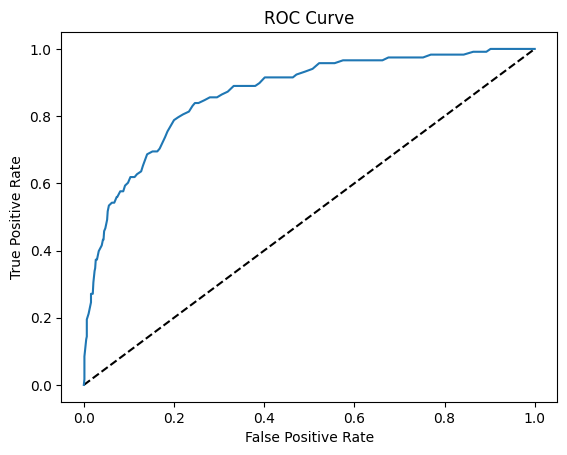

In [ ]:
target = train["ProdTaken"]
train = train.drop(columns=['ProdTaken'])

X_train, X_valid, y_train, y_valid = train_test_split(train, target, random_state = 42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

from imblearn.ensemble import BalancedRandomForestClassifier

# ランダムフォレストモデルを呼び出します。ランダムフォレストは実行するたびに学習結果が変わることがあるのでrandom_stateに数字を指定して結果を固定します。
model = BalancedRandomForestClassifier(random_state=42, n_estimators=120)

# model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
model.fit(X_train, y_train)

# predict_proba() で予測します。予測したいデータを入力します。
pred = model.predict_proba(X_valid)

# 予測の中身を確認します
print(pred[:5])

# AUCの評価はroc_auc_score(正解データ, 予測データ)で可能です。
# 成約したかどうかを判定するため、2列目の1の確率(成約している確率)を予測データとして入力します。
score = roc_auc_score(y_valid, pred[:, 1])
print(score)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# 予測

In [9]:
target = train["ProdTaken"]
train = train.drop(columns=['ProdTaken'])

from imblearn.ensemble import BalancedRandomForestClassifier

# ランダムフォレストモデルを呼び出します。ランダムフォレストは実行するたびに学習結果が変わることがあるのでrandom_stateに数字を指定して結果を固定します。
model = BalancedRandomForestClassifier(random_state=42, n_estimators=250)

# model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
model.fit(train, target)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(n_estimators=250, random_state=42)

# 提出

In [10]:
predict = model.predict_proba(test)

In [11]:
submit = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [12]:
submit[1] = predict[:, 1]

In [13]:
submit.head()

,0,1
0,3489,0.400
1,3490,0.512
2,3491,0.720
3,3492,0.624
4,3493,0.644


In [14]:
submit.to_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/submission.csv", index=False, header=None)